# Descripción

Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:

* Default: variable Binaria. Registra si el cliente entró en morosidad o no.
* Income: Ingreso promedio declarado por el cliente.
* Balance: total del saldo en la cuentra de crédito.
* Student: variable binaria. Registra si el cliente es estudiante o no.

# Ejercicio 1: Preparación del ambiente de trabajo:

* Importe las módulos básicos para el análisis de datos.
* Importe las clases LabelEncoder, StandarScaler y LabelBinarizer de preproccesing.
* Importe las funciones train_test_split y cross_val_score de model_selection
* Importe la función classification_report de metrics
* Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis.
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo.

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.metrics import classification_report

In [216]:
credit = pd.read_csv('default_credit.csv').drop(columns='index')
smarket=pd.read_csv('Smarket.csv')

In [217]:
credit.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [218]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


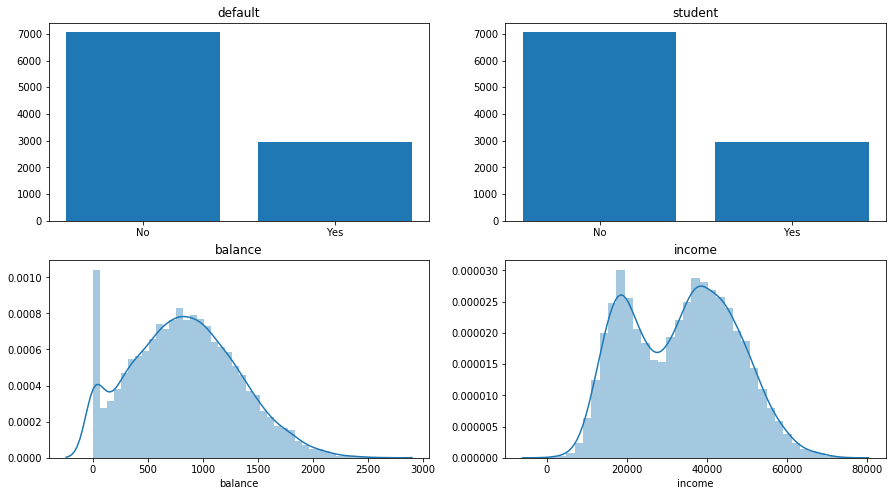

In [219]:
j=1
plt.figure(figsize=(15,8))
for i in credit.columns:
    plot = plt.subplot(2,2,j)
    if i == 'balance' or i=='income':
        sns.distplot(credit[i])
    else:   
        plt.bar(credit[i].unique(), credit['student'].value_counts())
    plt.title(i)
    j=j+1

# Ejercicio 2: Modelo Base

* Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. TRansforme los atributos pertinentes con Label Encoder

(Para este caso se debe transformar los parametros Default y Student)

In [220]:
lbl=LabelEncoder()
std=StandardScaler()

In [221]:
credit['new_default']=lbl.fit_transform(credit['default'])
credit['new_student']= lbl.fit_transform(credit['student'])

In [222]:
credit.head()

,default,student,balance,income,new_default,new_student
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [223]:
credit.head()

,default,student,balance,income,new_default,new_student
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [225]:
Y=credit['new_default']
datos=credit.drop(columns= 'new_default')
datos=datos.drop(columns= 'default')
datos=datos.drop(columns= 'student')

In [227]:
X_train, X_test, y_train , y_test = train_test_split(datos , Y, test_size=0.33, random_state=112)

In [247]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train , y_train)

LinearDiscriminantAnalysis()

In [248]:
lda_class_pred = lda_model.predict(X_test)

In [249]:
import lec4_graphs as afx

In [250]:
target_label = credit['default'].unique()

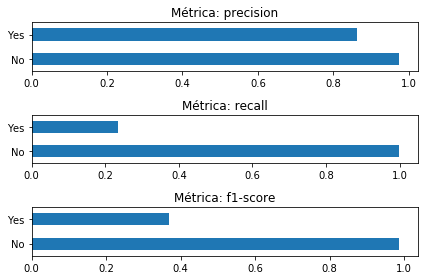

In [251]:
afx.plot_class_report(y_test, lda_class_pred, target_label)

Vemos que para la categoría de No Morosidad (0), el modelo es bastante bueno, encontrando el 100% de los verdaderos (recall) y muy pocos falsos positivos (precision). Sin embargo, para la categoría de Morosos (1), si bien se tienen pocos falsos positivos, la tasa de captacion de los positivos es muy baja (0.25). Como el objetivo de este modelo es identificar a clientes morosos, podemos decir que no es un buen modelo.

# Ejercicio 3: Refactorización 1 - información a priori

* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distibuciones 

- asumamos que hay 50/50 de morosos y no morosos.
- asumamos que hay un 60/40 de morosos y no morosos.

* Por cada modelo, reporte las métricas de clasificación.

In [235]:
lda_model_50 = LinearDiscriminantAnalysis(priors= [0.5,0.5])

In [238]:
lda_model_50.fit(X_train , y_train)

LinearDiscriminantAnalysis(priors=[0.5, 0.5])

In [239]:
lda_class_pred = lda_model_50.predict(X_test)

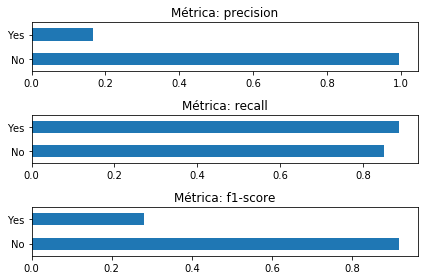

In [240]:
afx.plot_class_report(y_test, lda_class_pred, target_label)

In [242]:
lda_model_60 = LinearDiscriminantAnalysis(priors= [0.6,0.4])

In [243]:
lda_model_60.fit(X_train , y_train)

LinearDiscriminantAnalysis(priors=[0.6, 0.4])

In [244]:
lda_class_pred = lda_model_60.predict(X_test)

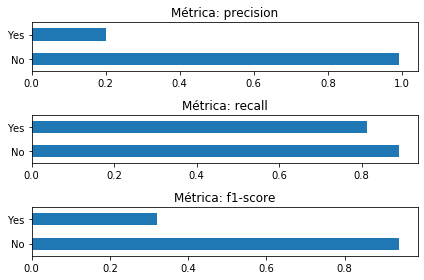

In [245]:
afx.plot_class_report(y_test, lda_class_pred, target_label)

En ambos casos, para la categoría de Morosos, tenemos una mejor captación de los casos positivos que en el modelo anterior. Sin embargo, vemos que también hay una alta tasa de falsos positivos, con una precvisión de 0.19. Eso hace que estos modelos sigan sin ser buenos para el cumplir el objetivo.

# Ejercicio 4: Refactorización 2 - oversampling
> **Digresión: Synthetic Over(Under)Sampling**
- Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como **Oversampling** cuando repetimos registros aleatorios de la clase minoritaria, y **Undersampling** cuando eliminamos aleatoriamente registros de la clase mayoritaria.
- Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
- Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos **en el espacio de atributos de la clase específica** mediante $\mathbf{x}{\textsf{nuevo-ejemplo}} = \mathbf{x}{i} + \lambda (\mathbf{x}{zi} - \mathbf{x}{i})$ donde $\mathbf{x}_{zi}$ es un ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.

- Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante **SMOTE** (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn`. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`
- Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, sampling_strategy='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

- Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [257]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, sampling_strategy='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [259]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_oversamp , y_train_oversamp)

LinearDiscriminantAnalysis()

In [260]:
lda_class_pred = lda_model.predict(X_test)

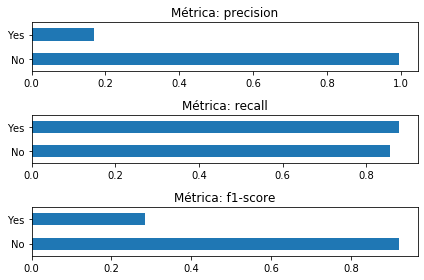

In [261]:
afx.plot_class_report(y_test, lda_class_pred, target_label)

Pese al aumento de los registros de la clase minoritaria, seguimos obteniendo resultados similares que los modelos anteriores, es decir, seguimos obteniendo una alta tasa de Falsos Positivos (precision de 0.16). Si bien, la tasa de positivos correctamente etiquetados es alta (recall de 0.93), el bajo rendimiento obtenido en precision hace que este modelo no cumpla con el equisito de poder identificar a los morosos del banco.